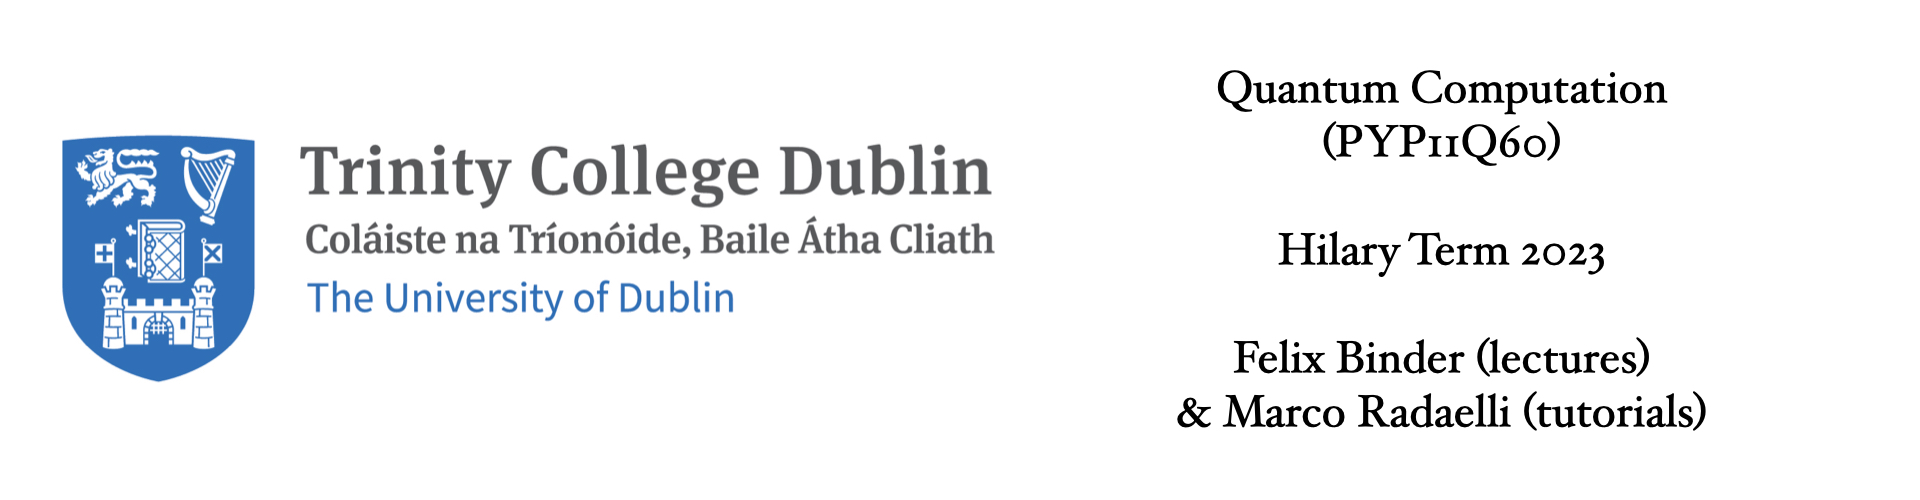

# Problem set 4

## General directions
<ul>
    <li>Some of the following exercises are numerical. They should be performed directly within this notebook. Other exercises are analytical, and should be solved on attached documents. You may submit handwritten solutions for the latter, but please make sure to write in a comprehensible manner.</li>
    <li>For the numerical tasks, please comment your code to explain what does what. Use meaningful names for variables and functions. </li>
    <li>We will need to be able to run the notebook. Make sure that there are no dependencies in the notebook based on files on your computer!</li>
    <li>Feel free to look online for help! Python documentation is <a href="https://docs.python.org/3/">here</a>, NumPy documentation <a href="https://numpy.org/doc/stable/">here</a>, and the Qiskit manual is <a href="https://qiskit.org/documentation/">here</a>. Some specific pages of Qiskit documentation or other useful sources are linked in the relevant questions.</li>
</ul>

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In [190]:
import numpy as np
from matplotlib import pyplot as plt
import qiskit
from qiskit import Aer, transpile, assemble
from qiskit.visualization import plot_histogram

<a id="reflection"></a>
# 4.1 - Inside the reflection operator (4 pts.)
In the lecture, we defined the reflection operator ${R}$ as
$$ {R} = 2\ket{\psi}\bra{\psi} - \mathbb{I},$$
where $\ket{\psi}$ is the equal superposition of all states, given by
$$ \ket{\psi} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \ket{x}.$$
<ol>
    <li> Create a Python function <code>generate_reflection(number_qubits)</code> which outputs a Qiskit quantum gate that performs the reflection operator on <code>number_qubits</code> qubits. Draw the quantum circuit yielding the gate for <code>number_qubits</code>=1, 2, 5.</li>
    <li> Prove that the operator ${R}$, applied to a generic state
    $$ \ket{\phi} = \sum_k \alpha_k \ket{k},$$
    produces the output state 
    $$\sum_k \left[-\alpha_k + 2 \overline\alpha \right]\ket{k},$$
    where 
    $$\overline\alpha := \sum_k \frac{\alpha_k}{N}.$$
         </li>
</ol>

In [148]:
def generate_reflection(number_qubits): 
    # Create circuit with number_qubits qubits
    grcirc = qiskit.QuantumCircuit(number_qubits)
    
    if number_qubits == 1:
        grcirc.h(range(number_qubits))
        grcirc.x(range(number_qubits))
        grcirc.x(range(number_qubits))
        grcirc.h(range(number_qubits))
        return grcirc.draw()
    
    # Apply Hadamard gate on number_qubits
    grcirc.h(range(number_qubits))
    
    # Apply negative phase to states orthogonal to |00...0> using XmczX
    grcirc.x(range(number_qubits))
    # Multi-controlled-Z ( Z = HXH)
    grcirc.h(number_qubits-1)
    grcirc.mct(list(range(number_qubits-1)), number_qubits-1)
    grcirc.h(number_qubits-1)
    
    grcirc.x(range(number_qubits))
    
    # Apply Hadamard gate on number_qubits
    grcirc.h(range(number_qubits))
    
    # Convert circuit to user-defined gate and return#
    R = grcirc.to_gate(label = 'R')
    
    return grcirc.draw(),R

In [149]:
n = 1
#qc = qiskit.QuantumCircuit(n)
#qc.append(generate_reflection(n),list(range(n)))
#qc.draw()
generate_reflection(n)

┌───┐┌───┐┌───┐┌───┐
q: ┤ H ├┤ X ├┤ X ├┤ H ├
   └───┘└───┘└───┘└───┘

In [150]:
n = 3
generate_reflection(n)[0]

┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [151]:
n = 5
generate_reflection(n)[0]

┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_2: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_3: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_4: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

# 4.2 - A Quantum Sudoku (5 pts. total)
In this exercise, we will use the Quantum Search protocol to solve a simplified version of the popular puzzle game <it>Sudoku</it>. In particular, we will consider a $2\times 2$ Sudoku, which is a table like this:

|   |   |
|---|---|
|$v_0$| $v_1$ |
| $v_2$ | $v_3$ |

where $v_j \in \{0,1\}$ for all $j$.

A sudoku is <b>valid</b> if and only if no symbol appears more than once in each row and in each column. In other words, we require that $v_0 \neq v_1$, $v_1 \neq v_3$, $v_2 \neq v_3$ and $v_0 \neq v_2$.

## 4.2.a Classical version (0.5 pt.)
<ol>
    <li>Prove that, once one of $v_0$, $v_1$, $v_2$ and $v_3$ is specified, the scheme is fully determined.</li>
    <li>Are all the inequality conditions above independent? Is it possible to use a smaller number of conditions? Comment on this.</li>
    <li>Write a Python function <code>sudoku_solver</code> that takes binary inputs <code>value</code> and <code>cell_index</code> and outputs solution of the game.</li></ol>

In [47]:
"""
4.2a
"""
def sudoku_solver(value, cell_index):
    """ Soduku solver for a 2x2 game """
    table = np.zeros([4])
    # Assign value to cell index of the table
    table[cell_index] = value
    
    if cell_index == 0 or cell_index == 0:
        table[0], table[3] = table[cell_index], table[cell_index]
        if value == 0:
            table[1], table[2] = value+1, value+1
    elif cell_index == 1 or cell_index == 3:
        table[1], table[2] = table[cell_index], table[cell_index]
        if value == 0:
            table[0], table[3] = value+1, value+1
        
    return print('\n| {} | {} |\n---------\n| {} | {} |'.format(int(table[0]),int(table[1]),int(table[2]),int(table[3])))

sudoku_solver(0,1)


| 1 | 0 |
---------
| 0 | 1 |


## 4.2.b A reversible solution checker (1 pts.)
The first step towards our quantum sudoku solver is to create a reversible logic to check whether a proposed solution is valid or not. In particular, we need to be able to test whether two given items are different, and this can be checked using a <code>XOR</code> gate.

Create a quantum circuit $\mathcal{X}$ performing a <code>XOR</code> gate on three qubits in this way:
$$\mathcal{X} \ket{a}\ket{b}\ket{c} = \ket{a}\ket{b}\ket{c \oplus XOR(a,b)}$$
Transform the circuit into a gate named <code>rXOR</code>.

In [222]:
"""
4.2.b
"""
def rXOR(a,b,c):
    """ XOR gate """
    qc = qiskit.QuantumCircuit(8)
    qc.cx(a,c)
    qc.cx(b,c)
    # Create user-defined gate
    rXOR = qc.to_gate(label = 'rXor')
    return rXOR

## 4.2.c Building the oracle /1 (0.5 pt.)
We will have to apply the solution checker four times to check the validity of a sudoku. We will store the result of the four checks in four qubits (each one of them will assume value 1 if the check is passed). The sudoku is valid if and only if all the check qubits are in state $\ket{1}$. We can use a fifth "general-control" qubit to check if all the check qubits are in $\ket{1}$. Here, a multi-controlled Toffoli gate can prove useful (see <a href="https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.mct.html">here</a>). 

Build a circuit which checks all the four conditions, putting the outcomes of the checks into four check qubits, and then verifies if all the conditions are met, storing the result in a further qubit. 

In [245]:
"""
4.2.c
"""
v_qubits = qiskit.QuantumRegister(4, name = 'v')
check_qubits = qiskit.qiskit.QuantumRegister(4, name = 'c')
gc_qubit = qiskit.QuantumRegister(1, name = 'out')

# The checks (cnots) which need to be performed
checks = [[0,1], [0,2], [1,3], [2,3]]

Oqc = qiskit.QuantumCircuit(v_qubits,check_qubits,gc_qubit)
#Oqc = qiskit.QuantumCircuit(9)

# Apply rXOR 4 times
for i in range(len(checks)):
    Oqc.append(rXOR(checks[i][0],checks[i][1],4+i),list(range(8)))

Oqc.mct(list(range(4,8)),8)

Oqc.decompose().draw()

»
v_0: ──■─────────■────────────────────────────────────────────────────»
       │         │                                                    »
v_1: ──┼────■────┼─────────■──────────────────────────────────────────»
       │    │    │         │                                          »
v_2: ──┼────┼────┼────■────┼─────────■────────────────────────────────»
       │    │    │    │    │         │                                »
v_3: ──┼────┼────┼────┼────┼────■────┼────■───────────────────────────»
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │            ┌────────┐     »
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────────────┤0       ├─────»
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │            │        │     »
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────────────┤1       ├─────»
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │            │  Rcccx │     »
c_2: ────────────────────┤ X ├┤ X ├──┼────┼────────────┤2       ├─────»
                         └───┘└───┘┌─┴─┐┌─┴─┐          │        │     »
c_3: ──────────────────────────────┤ X ├┤ X ├─■────────┤3       ├─────»
     ┌───┐                         └───┘└───┘ │U1(π/2) └─┬───┬──┘┌───┐»
out: ┤ H ├────────────────────────────────────■──────────┤ H ├───┤ H ├»
     └───┘                                               └───┘   └───┘»
«                                   
«v_0: ──────────────────────────────
«                                   
«v_1: ──────────────────────────────
«                                   
«v_2: ──────────────────────────────
«                                   
«v_3: ──────────────────────────────
«                ┌───────────┐      
«c_0: ───────────┤0          ├──■───
«                │           │  │   
«c_1: ───────────┤1          ├──■───
«                │  rcccx_dg │  │   
«c_2: ───────────┤2          ├──■───
«                │           │  │   
«c_3: ─■─────────┤3          ├──┼───
«      │U1(-π/2) └───┬───┬───┘┌─┴──┐
«out: ─■─────────────┤ H ├────┤ Sx ├
«                    └───┘    └────┘

## 4.2.d Building the oracle /2 (1 pt.)
Our circuit is not yet ready to function as an oracle. In fact, we would like to have an oracle $\mathcal{U}$ such that:
$$\mathcal{U} \ket{x}\ket{0}\ket{\mbox{out}_0} = \ket{x}\ket{0}\ket{\mbox{out}_0\oplus f(x)}$$
We therefore need to modify the circuit in order to restore the intermediate qubits set to $\ket{0}$ (the check qubits). Modify the previous circuit in order to reset the values to zero (avoid using <code>reset</code> instructions in order to preserve unitarity). Transform the circuit into a gate. This will be our oracle.

In [246]:
"""
4.2.d
"""
def reset_checks(a, b, c):
    qc = qiskit.QuantumCircuit(8)
    qc.cx(a,c)
    qc.cx(b,c)
    # Create user-defined gate
    reset = qc.to_gate(label = 'restore')
    return reset

for i in range(len(checks)):
    Oqc.append(reset_checks(checks[i][0],checks[i][1],4+i),list(range(8)))
oracle = Oqc.to_gate(label = 'Oracle')
Oqc.draw()

┌───────┐┌───────┐┌───────┐┌───────┐     ┌──────────┐┌──────────┐»
v_0: ┤0      ├┤0      ├┤0      ├┤0      ├─────┤0         ├┤0         ├»
     │       ││       ││       ││       │     │          ││          │»
v_1: ┤1      ├┤1      ├┤1      ├┤1      ├─────┤1         ├┤1         ├»
     │       ││       ││       ││       │     │          ││          │»
v_2: ┤2      ├┤2      ├┤2      ├┤2      ├─────┤2         ├┤2         ├»
     │       ││       ││       ││       │     │          ││          │»
v_3: ┤3      ├┤3      ├┤3      ├┤3      ├─────┤3         ├┤3         ├»
     │  rXor ││  rXor ││  rXor ││  rXor │     │  restore ││  restore │»
c_0: ┤4      ├┤4      ├┤4      ├┤4      ├──■──┤4         ├┤4         ├»
     │       ││       ││       ││       │  │  │          ││          │»
c_1: ┤5      ├┤5      ├┤5      ├┤5      ├──■──┤5         ├┤5         ├»
     │       ││       ││       ││       │  │  │          ││          │»
c_2: ┤6      ├┤6      ├┤6      ├┤6      ├──■──┤6         ├┤6         ├»
     │       ││       ││       ││       │  │  │          ││          │»
c_3: ┤7      ├┤7      ├┤7      ├┤7      ├──■──┤7         ├┤7         ├»
     └───────┘└───────┘└───────┘└───────┘┌─┴─┐└──────────┘└──────────┘»
out: ────────────────────────────────────┤ X ├────────────────────────»
                                         └───┘                        »
«     ┌──────────┐┌──────────┐
«v_0: ┤0         ├┤0         ├
«     │          ││          │
«v_1: ┤1         ├┤1         ├
«     │          ││          │
«v_2: ┤2         ├┤2         ├
«     │          ││          │
«v_3: ┤3         ├┤3         ├
«     │  restore ││  restore │
«c_0: ┤4         ├┤4         ├
«     │          ││          │
«c_1: ┤5         ├┤5         ├
«     │          ││          │
«c_2: ┤6         ├┤6         ├
«     │          ││          │
«c_3: ┤7         ├┤7         ├
«     └──────────┘└──────────┘
«out: ────────────────────────
«

## 4.2.e Quantum search (1 pt.)
It is now possible to apply the Quantum Search protocol to the sudoku. 

Write a Quantum Search algorithm to find the solutions for our $2\times 2$ Sudoku. Plot the outcome of the measurements and comment on the outcomes with highest probabilities.

The optimal solution is usually not found with 100% probability, especially on real (noisy) quantum hardware. Explain (in no more than 3 sentences) why this is not a fundamental issue here, using concepts from complexity theory and complexity classes. 

In [247]:
"""
4.2.e
"""
cbits = qiskit.ClassicalRegister(4, name = 'cr')
qc = qiskit.QuantumCircuit(v_qubits,check_qubits,gc_qubit,cbits)

qc.h(range(4))
# Apply oracle
qc.append(oracle, list(range(9)))
# Apply reflection operator
qc.append(generate_reflection(4)[1], list(range(4)))

qc.measure(v_qubits,cbits)

qc.draw()

┌───┐┌─────────┐┌────┐┌─┐         
 v_0: ┤ H ├┤0        ├┤0   ├┤M├─────────
      ├───┤│         ││    │└╥┘┌─┐      
 v_1: ┤ H ├┤1        ├┤1   ├─╫─┤M├──────
      ├───┤│         ││  R │ ║ └╥┘┌─┐   
 v_2: ┤ H ├┤2        ├┤2   ├─╫──╫─┤M├───
      ├───┤│         ││    │ ║  ║ └╥┘┌─┐
 v_3: ┤ H ├┤3        ├┤3   ├─╫──╫──╫─┤M├
      └───┘│         │└────┘ ║  ║  ║ └╥┘
 c_0: ─────┤4 Oracle ├───────╫──╫──╫──╫─
           │         │       ║  ║  ║  ║ 
 c_1: ─────┤5        ├───────╫──╫──╫──╫─
           │         │       ║  ║  ║  ║ 
 c_2: ─────┤6        ├───────╫──╫──╫──╫─
           │         │       ║  ║  ║  ║ 
 c_3: ─────┤7        ├───────╫──╫──╫──╫─
           │         │       ║  ║  ║  ║ 
 out: ─────┤8        ├───────╫──╫──╫──╫─
           └─────────┘       ║  ║  ║  ║ 
cr: 4/═══════════════════════╩══╩══╩══╩═
                             0  1  2  3

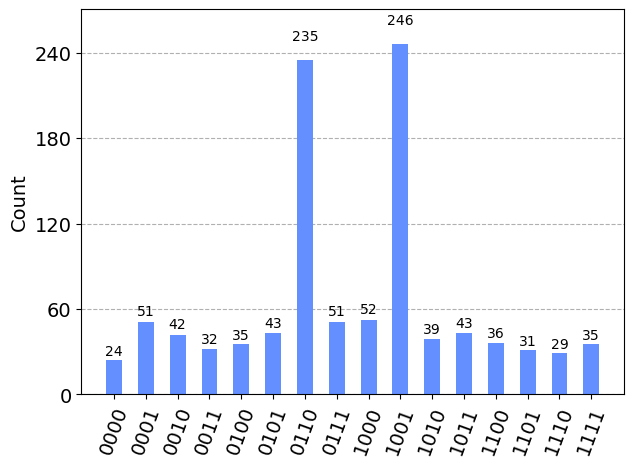

In [248]:
# Simulate and plot results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())

# 4.3 - Quantum Search on graphs (6 pts. total)

It is possible to set the Quantum Search algorithm on a suitably defined graph. In this exercise, you will employ a <b>continuous-time quantum walk</b> to solve a search problem. Consider a set $B$ of vertices of the graph that represents the possible solutions to be identified. Employing a suitably defined Hamiltonian, it will be possible to obtain that set.

Recall the definition of an undirected graph's adjacency matrix $A$:
$$A_{ij} = \begin{cases}1 & \mbox{ if nodes i and j are connected} \\ 0 & \mbox{ otherwise}\end{cases}.$$
We call an undirectd graph **complete** if any pair of its vertices are connected by an edge.

In addition to $A$, consider the degree matrix $D$, which is a diagonal matrix whose element $D_{ii}$ corresponds to the degree of vertex $i$, i.e. the number of the vertices connected to it. In the present case, it will be
$$ D_{ij} = \begin{cases} (N-1) & \mbox{ if } i=j \\ 0 & \mbox{otherwise}\end{cases},$$
where $N$ is the total number of vertices in the graph. Finally, the Laplacian matrix of the graph is the difference:
$$ L = A - D.$$

## 4.3.a Hermiticity of the Laplacian matrix, eigenspace of the Hamiltonian (1 pt.)
Show that the Laplacian of a complete, undirected graph is a Hermitian matrix. Hence, it can be used as a Hamiltonian. Usually, it is multiplied by a rate $\gamma$:
$$ \tilde{\mathcal{H}} = -\gamma L.$$
With this choice, each vertex of the graph is mapped onto a basis state $\ket{j}$. 

Compute the eigenvectors and eigenvalues for the Hamiltonian $\tilde{\mathcal{H}}$ for $\gamma=1$ and $N=4$ (either by hand or with Python).

Prove that also $-\gamma A$ is a valid choice for a Hamiltonian.

### Show that the Laplacian of a complete, undirected graph is a Hermitian matrix ### 
As $D_{ij}$ is a diagonal matrix $\implies$ $D^\dagger = D$, so it is hermitian.
The adjacency matrix $A_{ij}$ contains only real values, and for undirected graphs it is symmetric $\implies$ $A^\dagger = A$
Therefore, as $A$ is hermitian, and $D$ (so also $-D$) is hermitian $\implies L$ is also hermitian.

In [287]:
"""
4.3.a
"""
gamma, N = 1, 4
D = np.diag([N-1,N-1,N-1,N-1])
A = np.zeros([N,N], dtype = int)
for i in range(N):
    for j in range(N):
            for k in range(1,N):
                if i == j+k or i == j-k:
                    A[i][j] = 1
         
L = A - D
H = -gamma*L
#print('Hamiltonian :\n', H)
eigvals, eigvecs = np.linalg.eig(H)
print('\nEigenvalues :\n', eigvals,'\n\nEigenvectors :\n',eigvecs)
print('\nH = -𝛾A:\n', -gamma*A,'\nThis is also hermitian, and thus is a valid choice of Hamiltonian.')


Eigenvalues :
 [ 4.00000000e+00 -1.11022302e-16  4.00000000e+00  4.00000000e+00] 

Eigenvectors :
 [[ 0.8660254  -0.5        -0.05094267  0.18898224]
 [-0.28867513 -0.5         0.83206362 -0.31497039]
 [-0.28867513 -0.5        -0.39056048 -0.59165959]
 [-0.28867513 -0.5        -0.39056048  0.71764775]]

H = -𝛾A:
 [[ 0 -1 -1 -1]
 [-1  0 -1 -1]
 [-1 -1  0 -1]
 [-1 -1 -1  0]] 
This is also hermitian, and thus is a valid choice of Hamiltonian.


## 4.3.b Oracle Hamiltonian (1 pt.)
The next step is to perform a Quantum Search on the graph. Therefore, it is necessary to have means to recognize the solutions. Let $B$ be the subset of the points of the graph representing the solution; the <b>oracle Hamiltonian</b> is given by
$$ \mathcal{H}_{or} =  -\sum_{w \in B} \ket{w}\bra{w}.$$

Show that the search problem can be mapped onto the problem of finding the ground state of the Hamiltonian $\mathcal{H}_{or}$.

## 4.3.c Geometrical interpretation (2 pts.)
Consider now the overall Hamiltonian of the search problem, given by:
$$ \mathcal{H} = -\gamma A + \mathcal{H}_{or}.$$

Consider also the initial state $\ket{\psi_0}$ given by the balanced superposition of all the positions in the graph, i.e.
$$ \ket{\psi_0} = \frac{1}{\sqrt{N}}\sum_{j=0}^N \ket{j}.$$
Suppose also that there are $M \leq N$ solutions. 
<ol>
<li>With a similar approach as the one used in the lecture, consider the geometric representation in terms of the vector $\ket{\alpha}$ of non-solutions and of the vector $\ket{\beta}$ of solutions. Write $\ket{\psi_0}$ in terms of $\ket{\alpha}$ and $\ket{\beta}$. </li>
<li>Also express the Hamiltonian $\mathcal{H}$ in terms of $\ket{\alpha}$ and $\ket{\beta}$, and computes its eigenvalues and eigenvectors. Assume $\gamma=\frac{1}{N}$.</li>
<li>Compute the energy difference $\Delta E$ between the ground state and the excited state.</li>
</ol>

$\sqrt{\cos(\theta)}$

## 4.3.d Grover time (2 pts.)
Write explicitly the time evolution of the state $\ket{\psi_0}$ under the Hamiltonian $\mathcal{H}$, in the space spanned by $\ket{\alpha}$ and $\ket{\beta}$. Determine the Grover time $T_G$, i.e. the time which is necessary to get a state of the system exactly equal to the solution state $\ket{\beta}$.

Describe what happens if the position on graph is measured at time $t=T_G$.

# 4.4 - Looking for collisions (5 pts.)
Let us consider a function $f:\{0,1\}^n \to C$, such that it is 2-to-1: for each $x_j \in \{0,1\}^n$, there exists exactly one other $x_i$ such that $f(x_i) = f(x_j)$. A pair $(x_i, x_j)$ for which $f(x_i) = f(x_j)$ is called a <b>collision</b>. 
<ol>
    <li>Suppose $S$ is a uniformly-randomly chosen set of $s$ elements of $\{0,1\}^n$. What is the probability that there exists a collision in $S$?</li>
    <li>Give a quantum algorithm that finds a collision, with probability greater or equal than $\frac{2}{3}$, using $\mathcal{O}(N^{1/3})$ queries of the function $f$.</li>
</ol>

# 4.5 The 5-qubit error correcting code (6 pts.)
In the lecture, we discussed Shor's code, which employs 9 physical qubits to protect one logical qubit from any single-qubit error. It can be shown that it is possible to achieve the same result using a smaller code, consisting of only 5 physical qubits. 

The following is the table of the stabilizers for the 5-qubit code:

|  | qubit 1 | qubit 2 | qubit 3 | qubit 4 | qubit 5 |
| --- | --- | --- | --- | --- | ---|
| $M_1$ | $\sigma_x$ | $\sigma_z$ | $\sigma_z$ | $\sigma_x$ | $\mathbb{I}$ |
| $M_2$ | $\mathbb{I}$ | $\sigma_x$ | $\sigma_z$ | $\sigma_z$ | $\sigma_x$ |
| $M_3$ | $\sigma_x$ | $\mathbb{I}$ | $\sigma_x$ | $\sigma_z$ | $\sigma_z$ |
| $M_4$ | $\sigma_z$ | $\sigma_x$ | $\mathbb{I}$ | $\sigma_x$ | $\sigma_z$ |

<ol>
    <li> Show that any one-qubit error can be corrected by the 5-qubit code. </li>
    <li> Show that there exists (at least) one 2-qubit error that cannot be corrected by the 5-qubit code. </li>
    <li> The encoding of logical operations on a stabiliser code is not unique. One choice for the logical $Z$-gate is given by $Z_L=\sigma_z\otimes\sigma_z\otimes\sigma_z\otimes\sigma_z\otimes\sigma_z$. Suggest a valid encoding for the logical $X$-gate $X_L$ and explain how you obtained it. </li>
</ol>

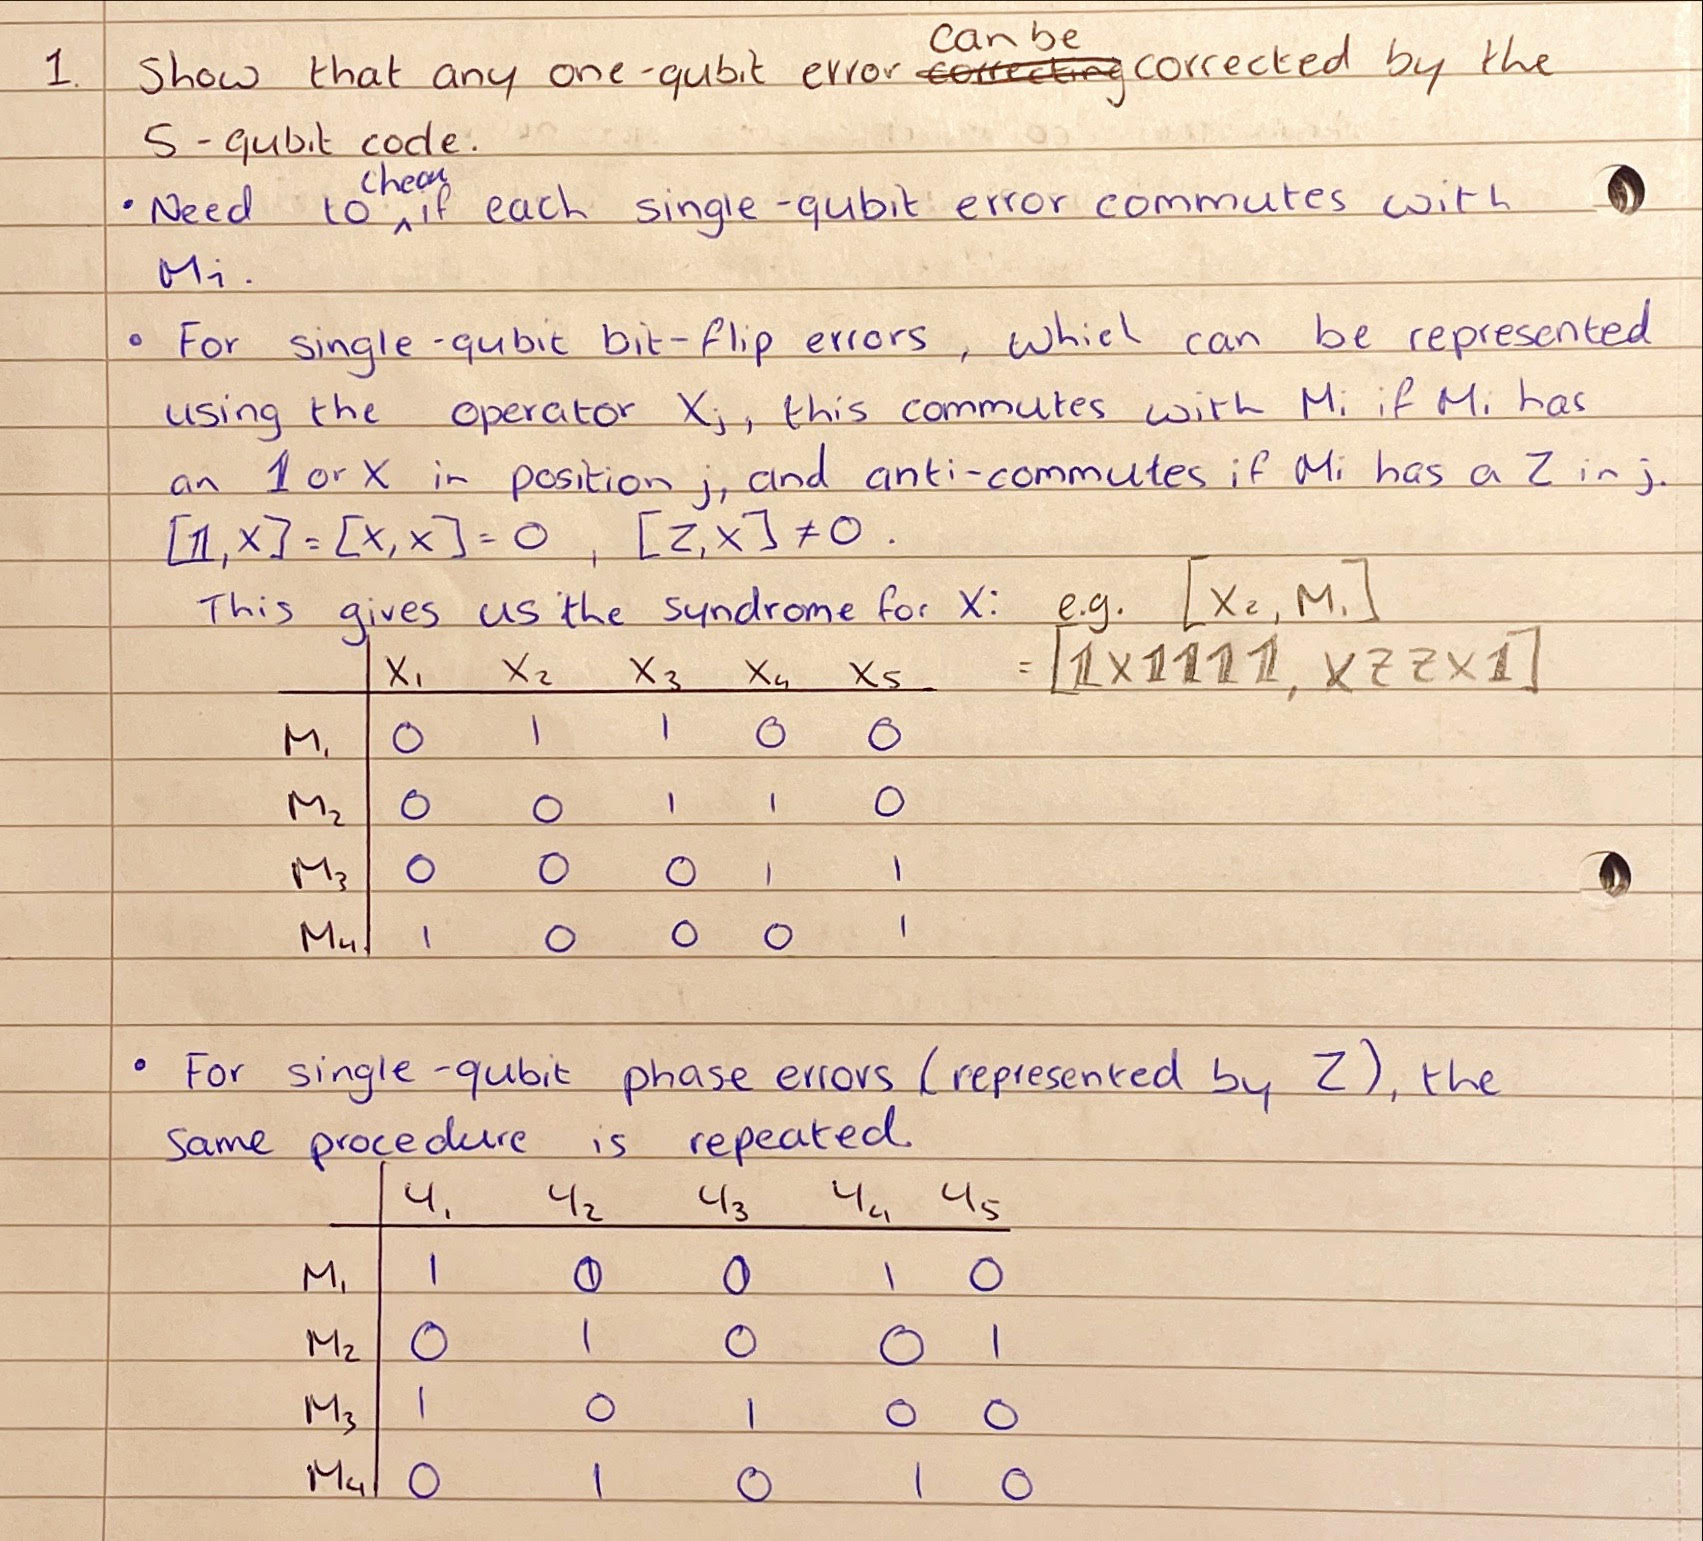

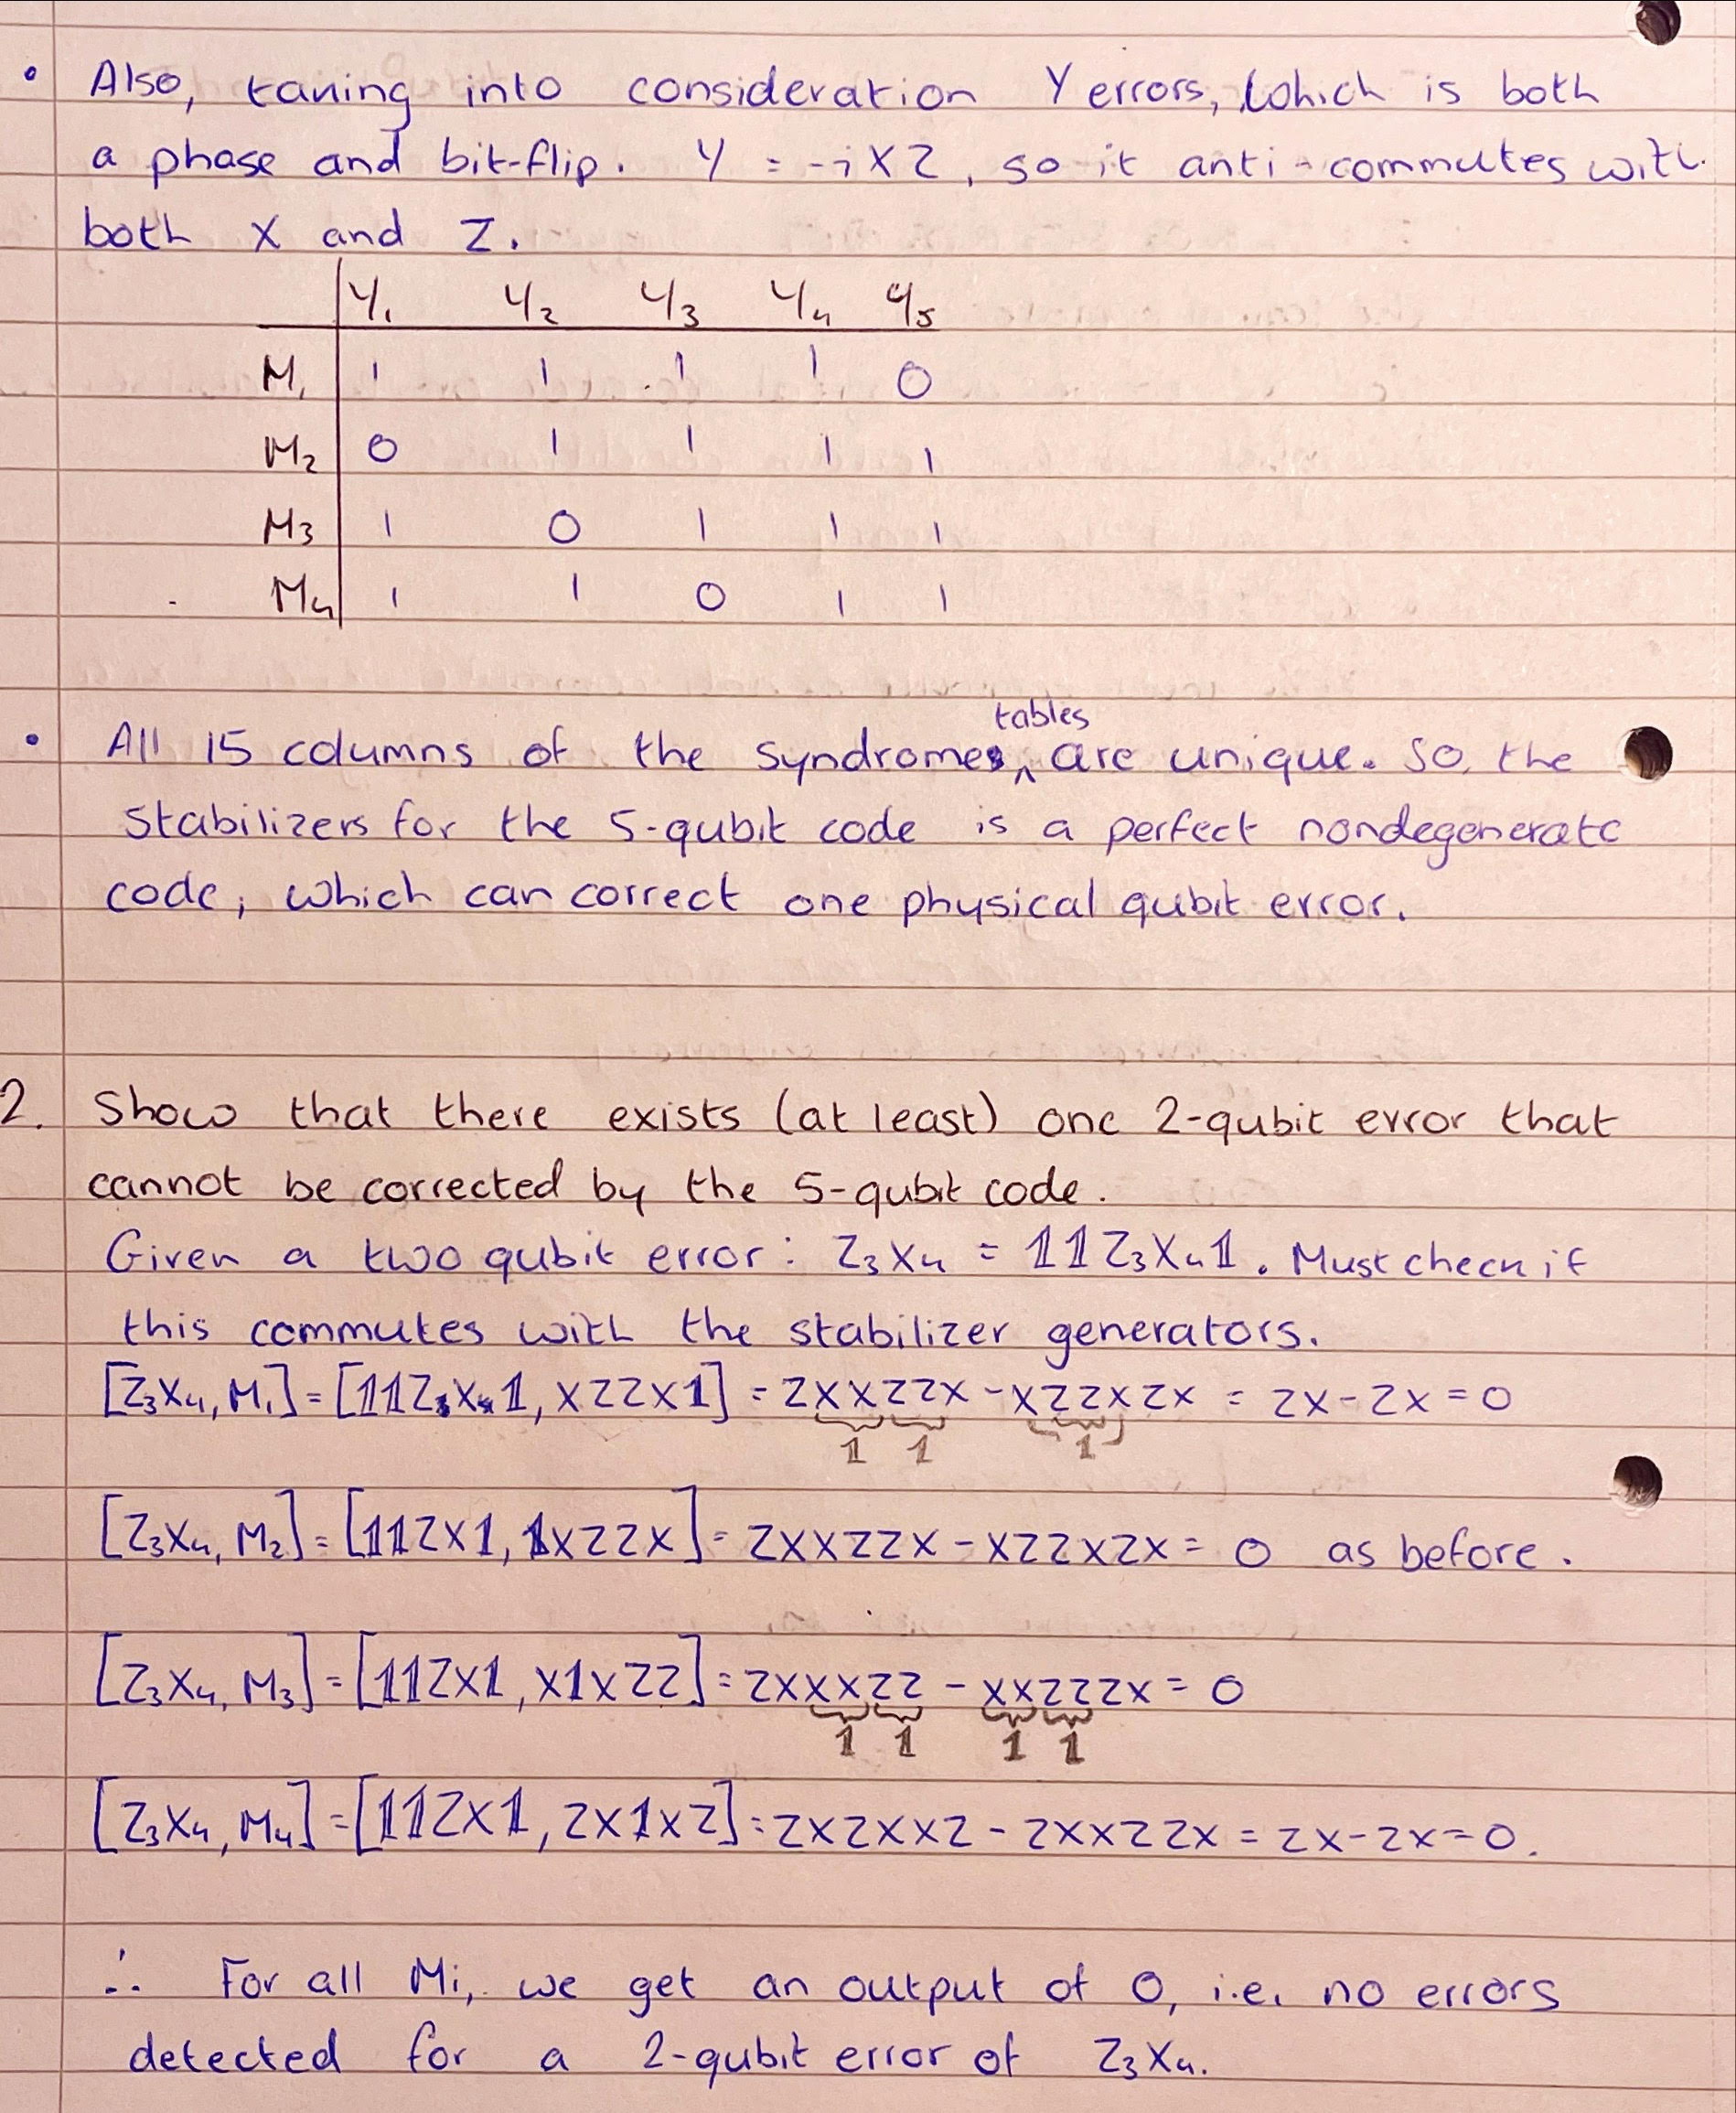

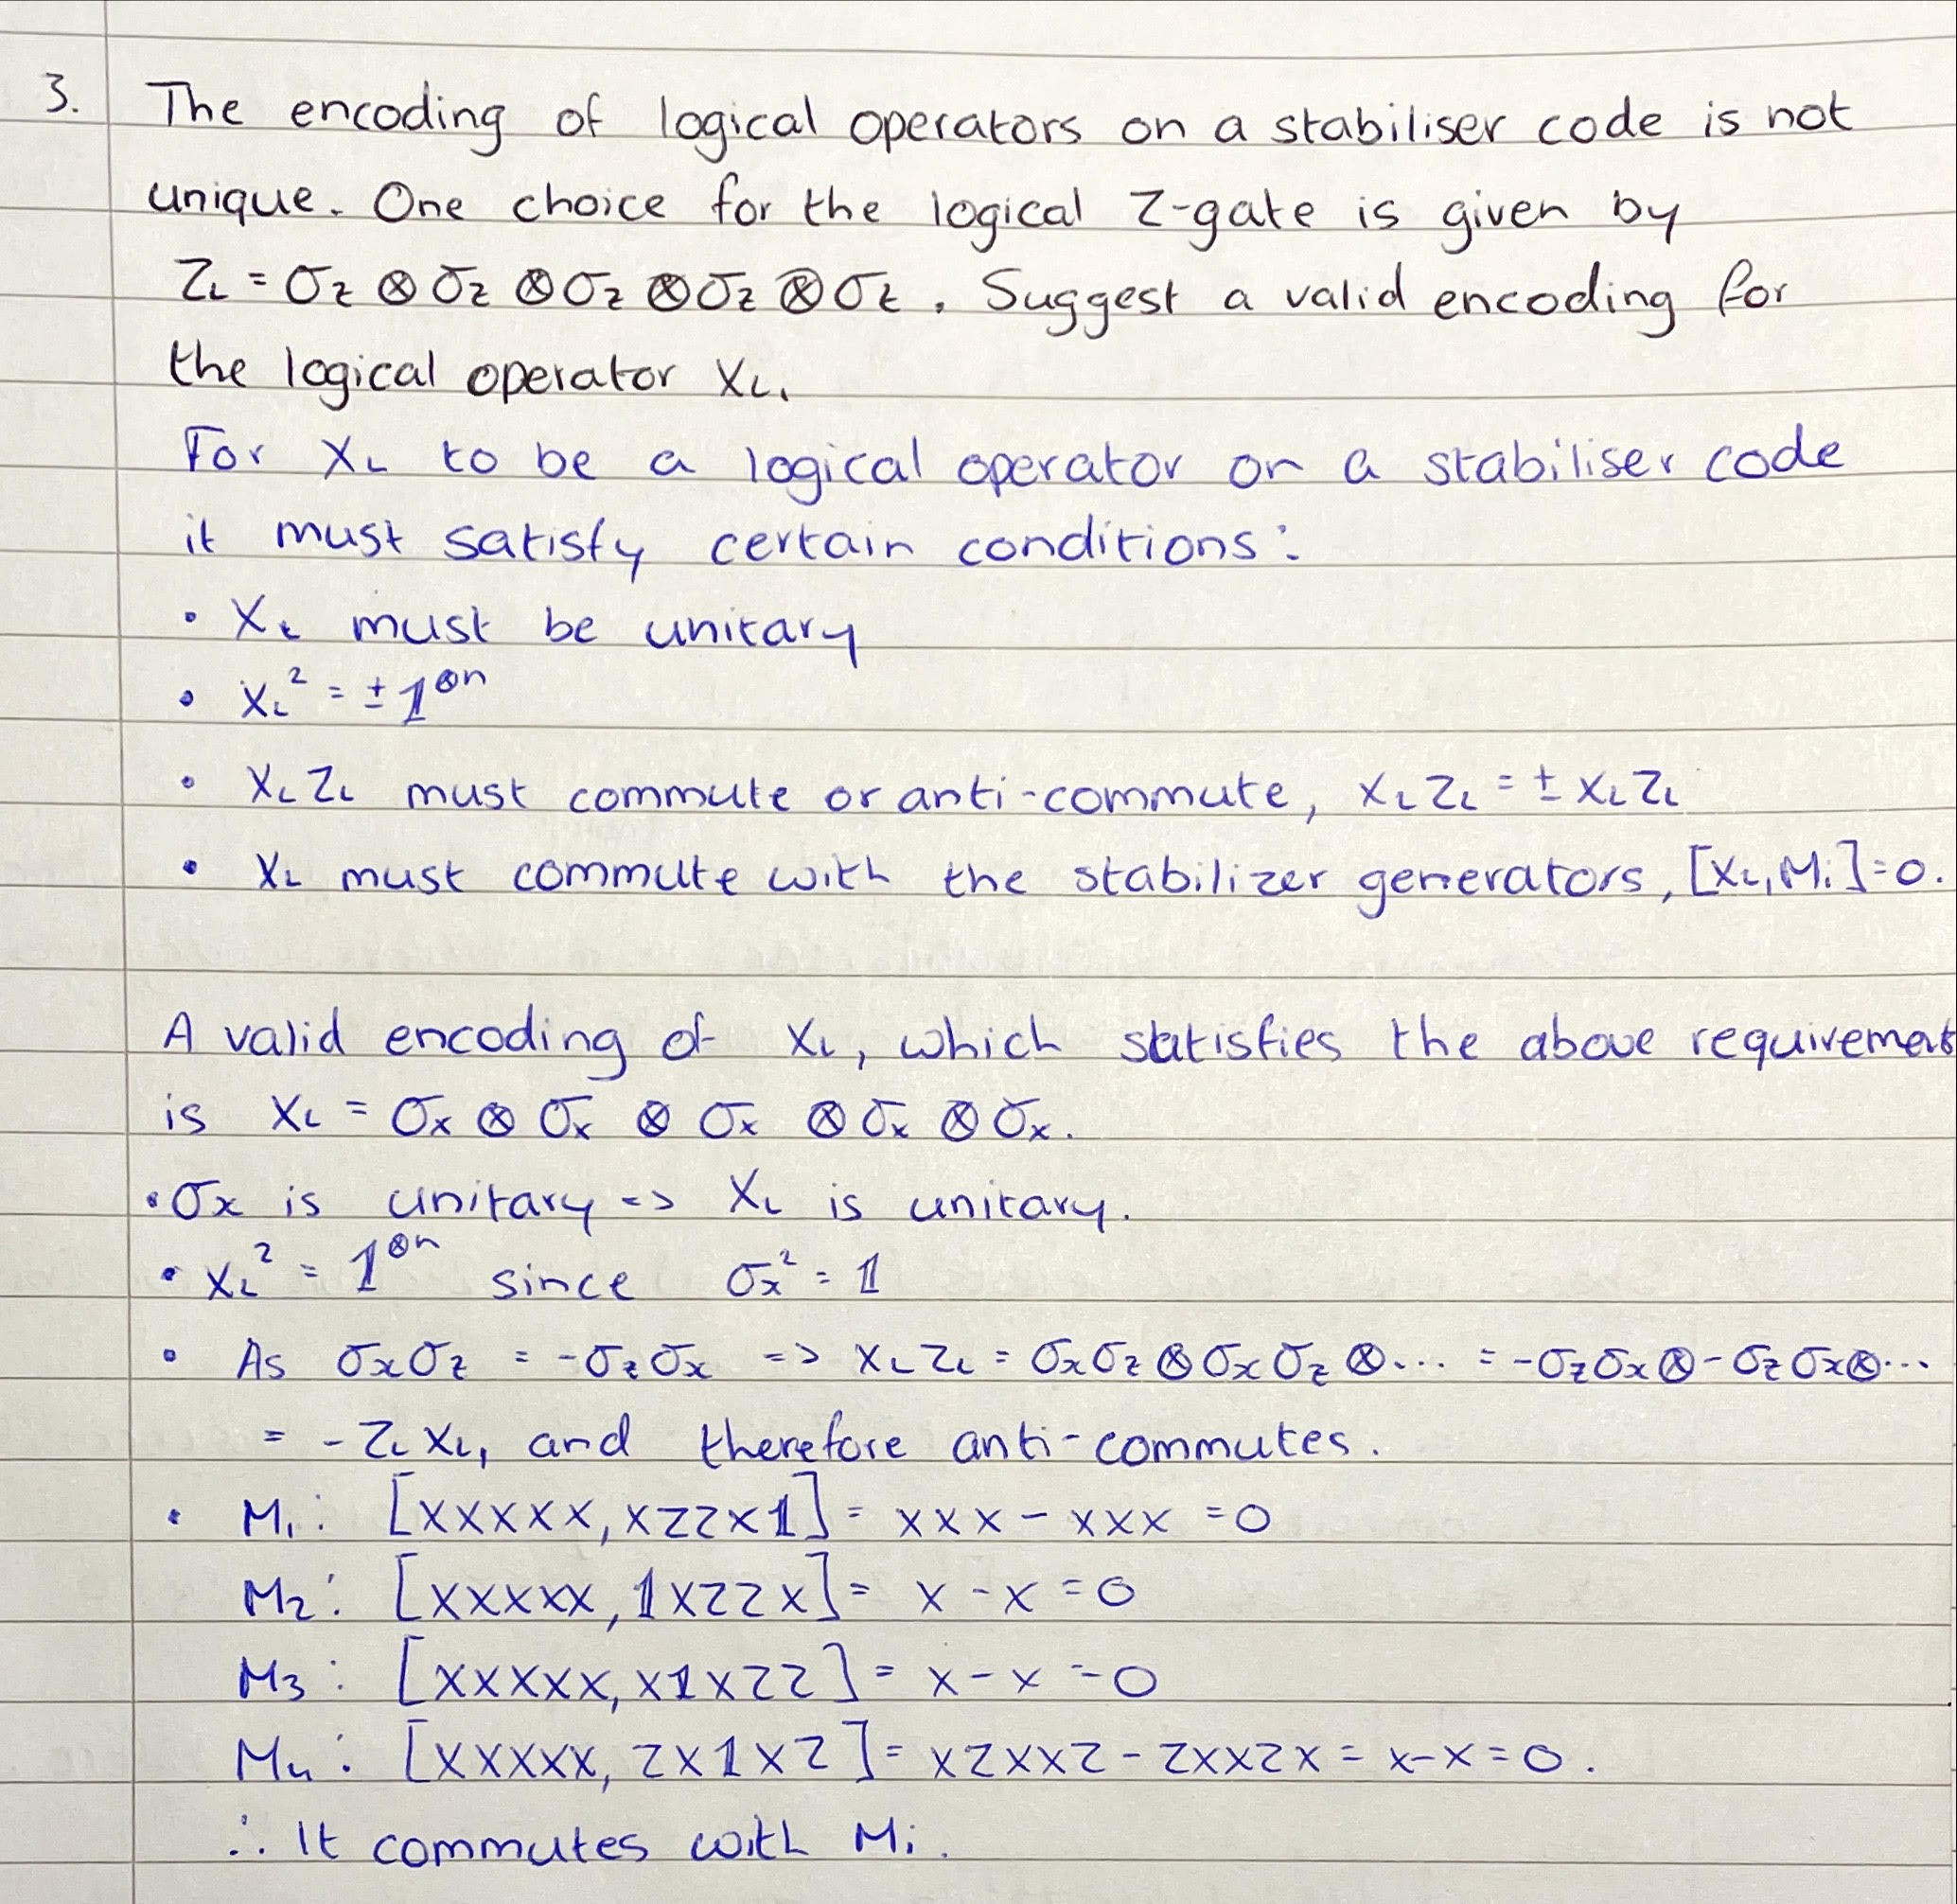